# GAN(Generative Adversarial Network) 生成对抗网络

GAN由Ian J. Goodfellow在2015年提出，被认为是深度学习领域中最重要的发明之一，今天我们将实现一个最简单的GAN用来生成MNIST手写字符图片
参考的材料有
+ [GAN论文](https://arxiv.org/abs/1406.2661)
+ [gan_mnist](https://github.com/jiemojiemo/deep-learning/blob/master/gan_mnist/Intro_to_GANs_Solution.ipynb)

## GAN简单介绍

![GAN](https://raw.githubusercontent.com/jiemojiemo/deep-learning/66dc1a9946f082aeb8dbd16e3d105fd075bc8728/gan_mnist/assets/gan_diagram.png)

GAN的由两部分组成：
+ 生成器(Generator)，用来生成假(fake)的数据，在生成MNIST任务中，输入为任意噪声（通常为高斯噪声），输出为一张图片
    >`Gaussuan noise --> Generator --> fake image`
+ 判别器(Discriminator),用来判断数据是否为真(real)，在MNIST任务中，输入为一张图片，输出是为真的概率在[0,1]之间
    >`fake/real image --> Discriminator --> probability of real`
    
这里有些例子，大概可以直观的解释一下GAN的工作原理

>造假者和警察：造假者造出假钞，他们的目的是以假乱真，也就是使得假钞越来越像真钞；警察的目的是判断一张钞票是真的还是假的，尽可能使将一张真钞判断为真，避免判断的失误。

> 魔术师和观众：魔术师能够变出一只假兔子，他需要确保这只兔子足够真实使得观众无法察觉出这是一只假兔子；而台下的观众总是希望能够找到魔术师的破绽，尽可能地判断魔术师变出来兔子的真假。

以上，造假者和魔术师就是生成器，警察和观众就是判别器

我们站在数学的角度来理解下GAN，论文中将GAN描述为一个"two-player minimax game"

$$
\min_G \max_D V(D,G) = \Bbb E_{x \sim p_{data}(x)}[\log D(x)] + \Bbb E_{z \sim p_{z}(z)}[\log(1 - D(G(z)))]
$$

这个部分我们分开两个部分看，首先是判别器，判别器D希望V的值**最大**
$$
\max_D V(D,G) = \Bbb E_{x \sim p_{data}(x)}[\log D(x)] + \Bbb E_{z \sim p_{z}(z)}[\log(1 - D(G(z)))]
$$
其中
1. $D(x) \in [0,1]$, $\log(D(x)) \in [-\infty ,0]$, $\Bbb E_{x \sim p_{data}(x)}[\log D(x)] \in [-\infty, 0]$
2. $1-D(G(z)) \in [0,1]$, $\log(1-D(G(z))) \in [-\infty, 0]$, $\Bbb E_{z \sim p_{z}(z)}[\log(1 - D(G(z))) \in [-\infty, 0]$

那么 $V(D,G) \in [-\infty, 0]$

当$D(x)=1, D(G(z))=0$时 V的最大值为0，从这可以看出，GAN要求判别器能够"明辨是非"：
+ 当 $x \sim p_{data}$时（当 x 是real时），判别器要判断为真的概率越靠近1越好
+ 当 $x \sim p_{z}$时（当 x 是 fake时），判别器要判断为真的概率越靠近0越好

然后我们看生成器，生成器G希望V的值**最小**(注意，只有后面那一项出现了G，所以下面的公式只有后面那一项)
$$
\min_G V(D,G)= \Bbb E_{z \sim p_{z}(z)}[\log(1 - D(G(z)))]
$$
其中
1. $1-D(G(z)) \in [0,1]$, $\log(1-D(G(z))) \in [-\infty, 0]$, $\Bbb E_{z \sim p_{z}(z)}[\log(1 - D(G(z))) \in [-\infty, 0]$

那么 $V(D, G) \in [-\infty, 0]$

当$D(G(z))=1$时，V的最小值为$-\infty$，从这可以看出，GAN要求生成器欺骗判别器：
+ 当 $x \sim p_{z}$时（当 x 是fake）时，生成器要将x进行变化，使得让判别器判断x为真的概率越靠近1越好

## GAN MNIST

废话讲太多了，我们上代码，以下代码参考了 [gan_mnist](https://github.com/jiemojiemo/deep-learning/blob/master/gan_mnist/Intro_to_GANs_Solution.ipynb)

原来的代码用的是Tensorflow，在这里我们将结合keras，因为keras封装好的各种层真的好方便啊

这里使用MNIST数据集，我们将MNIST的数据拉成一维

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

/home/student1/anaconda3/envs/keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 导入数据
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# 模型输入
# 输入有两个：真实图像输入 和 高斯噪声输入
def model_input(real_dim, z_dim):
    '''
    
    Args:
        real_dim, 真实图像的大小，例如MNIST中为 28*28 = 784
        z_dim, 高斯噪声的大小
        
    Returns:
        两个输入的张量
    '''
    
    inputs_real = tf.placeholder(tf.float32, [None, real_dim], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    
    return inputs_real, inputs_z

### 网络模型

![Generator_network](https://raw.githubusercontent.com/jiemojiemo/deep-learning/66dc1a9946f082aeb8dbd16e3d105fd075bc8728/gan_mnist/assets/gan_network.png)

In [4]:
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    '''
    生成网络
    Args:
        z, 高斯噪声输入
        out_dim, 输出的大小，例如在MNIS中为MNIST
        n_units, 中间隐藏层的单元个数
        reuse, 是否重复使用
        alpha, LeakyReLU的参数
        
    Returns:
        生成的数据
    '''
    with tf.variable_scope('generator', reuse=reuse):
        h1 = tf.keras.layers.Dense(n_units)(z)
        h1 = tf.keras.layers.LeakyReLU(alpha)(h1)
        
        out = tf.keras.layers.Dense(out_dim, activation='tanh')(h1)
        
    return out

In [5]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    '''
    判别网络
    Args:
        x, 输入的图像
        n_units, 中间隐藏层的单元个数
        reuse, 是否重复使用
        alpha, LeakyReLU的参数
        
    Returns:
        为真的概率
    '''
    
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.keras.layers.Dense(n_units)(x)
        h1 = tf.keras.layers.LeakyReLU(alpha)(h1)
        
        logits = tf.keras.layers.Dense(1)(h1)
        out = tf.keras.layers.Activation('softmax')(logits)
    return out, logits

In [6]:
# 超参数

# 28*28 for mnist
input_size = 784
# 高斯噪声输入大小
z_size = 100
# 隐层神经元个数
g_hidden_size = 128
d_hidden_size = 128
# Leak factor
alpha = 0.01
# Smoothing，用于平滑label(后面有解释)
smooth = 0.1

### 建立网络

In [7]:
tf.reset_default_graph()
# 建立输入
input_real, input_z = model_input(input_size, z_size)

# 生成器
g_model = generator(input_z, input_size, g_hidden_size, alpha=alpha)

# 判别器
d_model_real, d_logits_real = discriminator(input_real, d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

## 判别器和生成器的Losses

判别器的loss为 `d_loss = d_loss_real + d_loss_fake`, `d_loss_real`和`d_loss_fake`用的是二元交叉熵

对于真实图像，给定的label全为1，但是作者认为1这个目标有点难，为了让网络更容易训练，把1降低为0.9
对于假图像，给定的label全为0

生成器的loss为 `g_loss`，生成器希望欺骗判别器，因此给定的label全为1

In [8]:
'''
d_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(d_model_real)*(1-smooth), d_model_real))
d_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(d_model_fake), d_model_fake))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(d_model_fake), d_model_fake))
'''

'\nd_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(d_model_real)*(1-smooth), d_model_real))\nd_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(d_model_fake), d_model_fake))\nd_loss = d_loss_real + d_loss_fake\n\ng_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(d_model_fake), d_model_fake))\n'

In [9]:
# Calculate losses

d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))

### 优化器
生成器和判别器是独立的，因此在训练时我们用两个优化器分别对其训练

In [10]:
learning_rate = 0.002

# 获取相应要训练的变量
g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

### 进行训练

In [11]:
batch_size = 100
epochs = 100
samples = []
losses = []

# 只保存生成器变量
saver = tf.train.Saver(var_list = g_vars)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        for ii in range(mnist.train.num_examples // batch_size):
        
            # 获取一个batch的数据
            batch = mnist.train.next_batch(batch_size)
            # 将图片拉伸至一维
            batch_images = batch[0].reshape((batch_size, 28*28))
            # 预处理数据
            batch_images = batch_images*2 - 1
            
            # 高斯噪声输入
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real:batch_images, input_z:batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z:batch_z})
            
        train_loss_d = sess.run(d_loss, {input_z:batch_z, input_real:batch_images})
        train_loss_g = g_loss.eval({input_z:batch_z})
        
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))
        
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, reuse=True),
                       feed_dict={input_z: sample_z})
        
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')
        
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.3538... Generator Loss: 4.1175
Epoch 2/100... Discriminator Loss: 0.8443... Generator Loss: 1.2697
Epoch 3/100... Discriminator Loss: 1.0744... Generator Loss: 11.1795
Epoch 4/100... Discriminator Loss: 3.5870... Generator Loss: 1.4872
Epoch 5/100... Discriminator Loss: 3.9371... Generator Loss: 0.5618
Epoch 6/100... Discriminator Loss: 1.7787... Generator Loss: 0.8756
Epoch 7/100... Discriminator Loss: 1.6583... Generator Loss: 1.8493
Epoch 8/100... Discriminator Loss: 1.7657... Generator Loss: 1.5118
Epoch 9/100... Discriminator Loss: 1.7330... Generator Loss: 1.0911
Epoch 10/100... Discriminator Loss: 0.8375... Generator Loss: 4.1360
Epoch 11/100... Discriminator Loss: 4.6800... Generator Loss: 0.7573
Epoch 12/100... Discriminator Loss: 1.2294... Generator Loss: 1.0676
Epoch 13/100... Discriminator Loss: 1.5328... Generator Loss: 1.1388
Epoch 14/100... Discriminator Loss: 0.9903... Generator Loss: 1.4258
Epoch 15/100... Discriminator Loss: 0.8329

### Training Loss

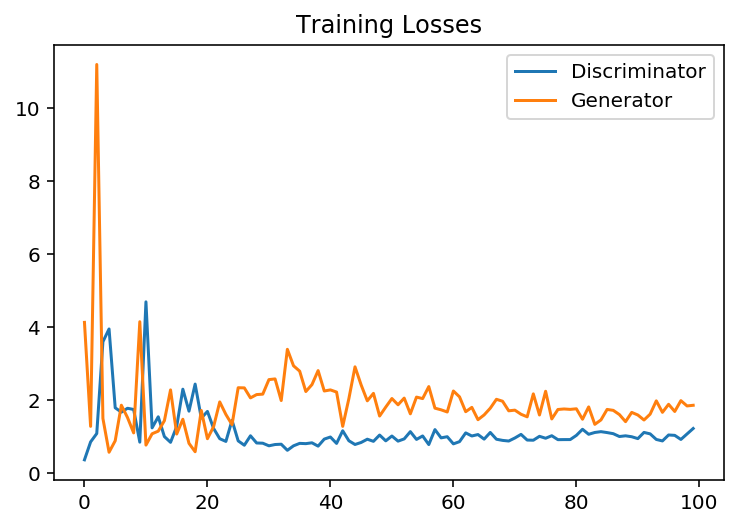

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### 训练的结果

In [13]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [14]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

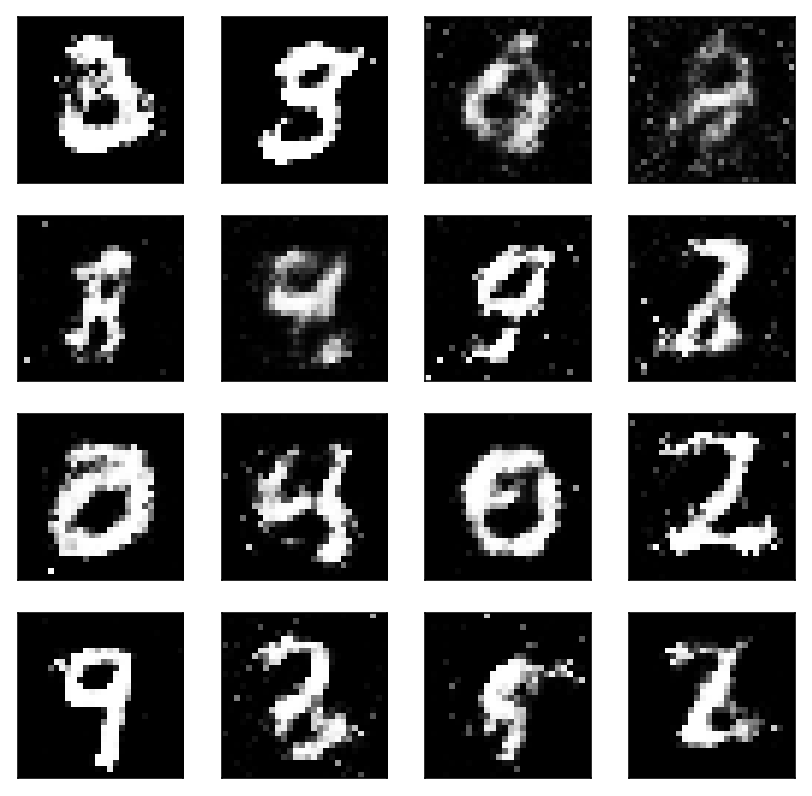

In [15]:
_ = view_samples(-1, samples)

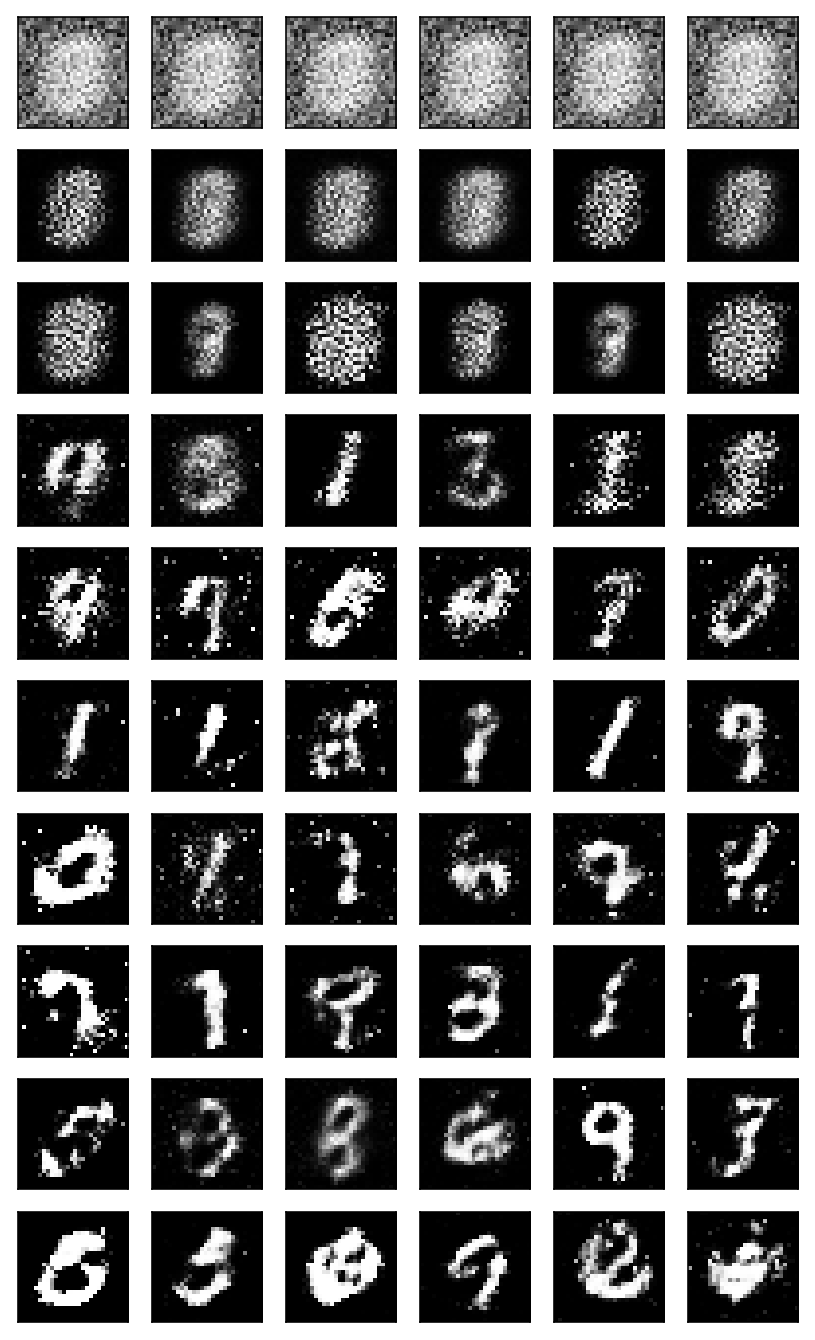

In [16]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### Sampling from the generator

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


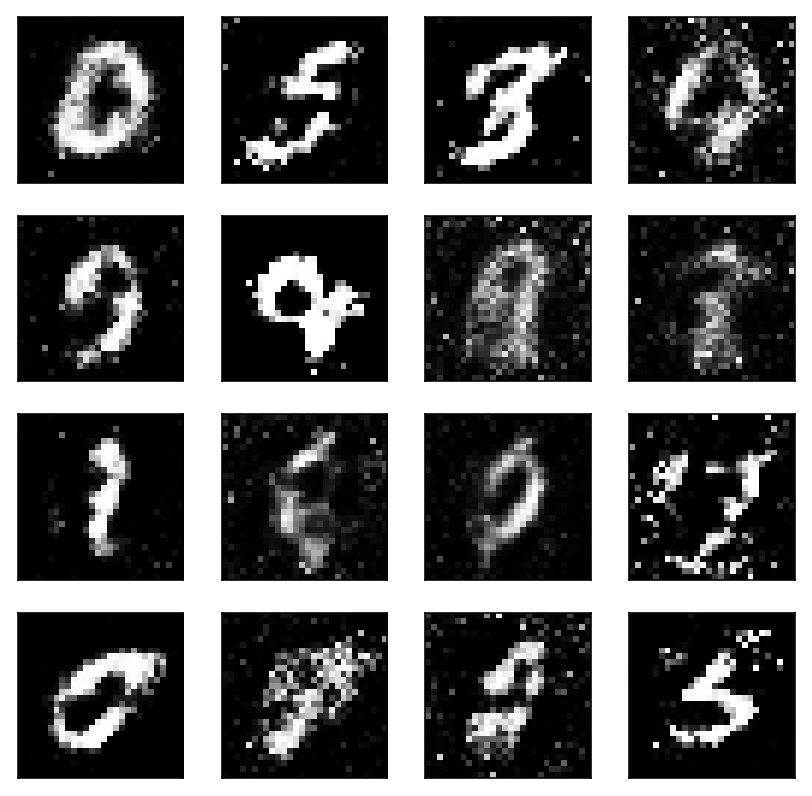

In [17]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, reuse=True),
                   feed_dict={input_z: sample_z})
_ = view_samples(0, [gen_samples])